<center>  <h1> Data 598 (Winter 2022): HW5 </h1> </center> 
    <center> University of Washington </center>
    
Please fill out all the `TODO`s in the notebook below. 

# Coding up a differentiable module

Consider the soft-thresholding function $f_T: \mathbb{R} \to \mathbb{R}$ defined for any $T > 0$ as 
$$
    f_T(y) = 
    \begin{cases} 
        0, & \text{ if } -T \le y \le T \,, \\
        y - T, & \text{ if } y > T \,, \\
        y + T, & \text{ if } y < T \,.
    \end{cases}
$$

See the image below for $T=3$. 
<img src="https://d3i71xaburhd42.cloudfront.net/32c265c127e6985e365b93158123655e13768ea4/6-Figure2-1.png" width="300">



**A)** Write a function to compute which takes in as arguments $y, T$ and returns the soft-thresholding $f_T(y)$.
    Plot this function with $T = 3.14$ in the range $[-10, 10]$.

In [1]:
import numpy as np
import torch

# Example of PyTorch Scalar
x = torch.tensor(3.14159, requires_grad=True)
print(x)

tensor(3.1416, requires_grad=True)


In [2]:
import matplotlib.pyplot as plt
def softt(y, T):
    """ `y` is a torch.tensor (i.e., PyTorch's scalar type; same as above), 
        `T` is a regular Python number (float or int).
        return type: torch.tensor
    """
    # HINT: if you write a program with branches, make sure that the output type is always a torch.tensor    
    if -T <= y <= T:
        return torch.zeros(1, requires_grad=True)
    elif y > T:
        return y - T
    elif y < (-1 * T):
        return y + T
    
    return None


/home/apoorvsharma/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 0, 'X')

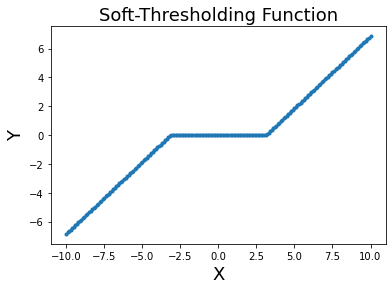

In [3]:
x_list = np.arange(-10, 10.1, 0.1)
T = 3.14159
y_list = [softt(torch.tensor(x, requires_grad=True), T).detach().numpy() for x in x_list]

f = plt.figure()
ax = f.gca()
ax.plot(x_list, y_list, '.')
ax.set_title('Soft-Thresholding Function', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
ax.set_xlabel('X', fontsize=18)

**B)** Write a function which computes the derivate $f_T'(y)$ of the soft-thresholding function w.r.t. $y$, as returned by PyTorch. Plot this for $T=3.14$ in the range $[-10, 10]$. 

**Hint 1**: If you coded up `softt` using branches, you might encounter a situation where the output does not depend on the input. In this case, you will have to appropriately set the `allow_unused` flag. 

**Hint 2**: When PyTorch returns a derivative of `None`, it actually stands for `0`. If your derivative returns a `None`, you will have to handle this appropriately when plotting the function.

0


Text(0.5, 0, 'X')

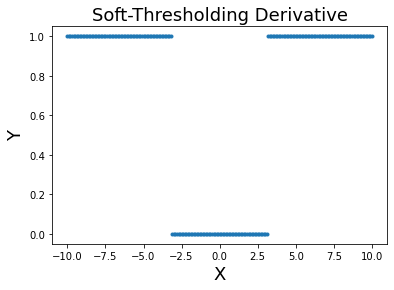

In [4]:
def softt_derivative(y, T): 
    # TODO: your code here
    # Call torch.autograd.grad to compute the derivative
    
    fy = softt(y, T)
    fy_prime = torch.autograd.grad(outputs=fy, inputs=[y], allow_unused=True)[0]
    if fy_prime == None: fy_prime = 0
    return fy_prime

# Test your code
a = torch.tensor(1.20, requires_grad=True)
print(softt_derivative(a, 3.14))

# Plot
x_list = np.arange(-10, 10.1, 0.1)
T = 3.14159
y_list = [softt_derivative(torch.tensor(x, requires_grad=True), T) for x in x_list]

f = plt.figure()
ax = f.gca()
ax.plot(x_list, y_list, '.')
ax.set_title('Soft-Thresholding Derivative', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
ax.set_xlabel('X', fontsize=18)

**C)** We will now code a differentiable module using `torch.nn.Module`. 

First, let us extend the definition of 
the soft-thresholding $f_T$ to vectors by applying the soft-thresholding operation component-wise. 

Now write a differentiable module which implements the transformation $g_{T}(x, A; M)$ given by 
$$
    g_{T}(x, A; M) = M^{-1} \, f_T\big( (A^{-1} A)^n  Mx \big) \,,
$$

where $n=10000$ is given. Note that we can simplify $ A^{-1} A = I$ to obtain the same result. However, our chain (going right to left) contains the repetitive and unnecessary computation of multiplying $Mx$ by $A$ and then immediately undoing it by multiplying by $A^{-1}$. 

Note that $x \in \mathbb{R}^d$ is a vector, $A \in \mathbb{R}^{d\times d}$ is an invertible matrix and the output is a vector is a vector in $\mathbb{R}^d$.

Here, $M \in \mathbb{R}^{d \times d}$, a symmetric matrix, is a *parameter* of the module. (Recall: parameters maintain state of the module; register a parameter in `torch.nn.Module` by using the `torch.nn.Parameter` wrapper).

Supply $T > 0$ and and initial value $M_0 \in \mathbb{R}^{d \times d}$ symmetric to the constructor, while the `forward` method only accepts $x \in \mathbb{R}^d$ as an input. 

You may use the function `create_symmetric_invertible_matrix` to initialize this matrix `M` in the constructor.

In [5]:
class WastefulMatmulSofttMatmulinv(torch.nn.Module):
    def __init__(self, T, M, n=10000):
        super().__init__()
        self.M = torch.nn.Parameter(M)
        self.T = T
        self.n = n
    
    def forward(self, x, A):
        IMx = torch.matmul(self.M, x)
        for _ in range(self.n):
            IMx = torch.matmul(torch.linalg.inv(A), IMx)
            IMx = torch.matmul(A, IMx)
        fy = torch.FloatTensor([softt(val, self.T) for val in IMx]).double()
        result = torch.matmul(torch.linalg.inv(self.M), fy)
        
        return result
    
    '''
    def forward(self, x, A):
        #Ainv_A = torch.pow(torch.matmul(torch.linalg.inv(A), A), self.n)
        Ainv_A = torch.eye(x.shape[0]).double()
        for _ in range(self.n):
            Ainv_A = torch.matmul(Ainv_A, torch.linalg.inv(A))
            Ainv_A = torch.matmul(Ainv_A, A)
        
        AMx = torch.matmul(torch.matmul(Ainv_A, self.M), x)
        
        fy = AMx.detach().apply_(lambda val: softt(val, self.T))
        result = torch.linalg.inv(self.M) * fy
        
        return result
    '''
    

**D)** Initialize the module with $T = 3.14$ and $M_0$ using the function `create_symmetric_invertible_matrix` with `seed=0`.  
Use `dimension=5`. Pass in the following vector `x` and matrix `A` defined below and compute $g_T(x, A;M_0)$.

In [6]:
import numpy as np
def create_symmetric_invertible_matrix(dimension, seed=0):
    # return symmetric invertible square matrix of size `dimension` x `dimension`
    rng = np.random.RandomState(dimension + seed)
    factor = rng.randn(dimension, dimension)  # use dtype double
    return 1e-6 * torch.eye(dimension) + torch.from_numpy(np.matmul(factor, factor.T))

dimension = 5
x = torch.DoubleTensor([0.1, 5, -2.3, -1, -2]).requires_grad_(True)  # use dtype double
A = create_symmetric_invertible_matrix(dimension, seed=10).requires_grad_(True)
print('x:', x)

M_0 = create_symmetric_invertible_matrix(x.shape[0])
T = 3.14
wasteful = WastefulMatmulSofttMatmulinv(T, M_0)
gt_wasteful = wasteful(x, A)
print(gt_wasteful)

x: tensor([ 0.1000,  5.0000, -2.3000, -1.0000, -2.0000], dtype=torch.float64,
       requires_grad=True)
tensor([-0.6328,  6.8930, -0.5180,  1.2438, -0.6816], dtype=torch.float64,
       grad_fn=<MvBackward0>)


**E)** For the same vector `x` as defined above, compute and print out the gradient of $\varphi_T(x, A; M) = \|x - g_T(x, A; M)\|_2^2$
with respect to $x$, $A$, and $M$ using automatic differentiation. Use $T=3.14$ again.

Time the computation of the gradient using Python's `time` module. 

In [7]:
import time

start = time.time()
grad_wasteful = torch.autograd.grad(outputs=torch.pow(torch.linalg.norm(x - wasteful(x, A)), 2), inputs=[x, A, wasteful.M], allow_unused=True)[0]
print(f'Computation Time: {time.time() - start:.4f} seconds')

Computation Time: 0.7804 seconds


**F)** Repeat parts C-E above but with an efficient version of `WastefulMatmulSofttMatmulinv` that utilizes the simplification $A^{-1} A = I$ to return the exact same output. 

Note how much time the computation of the gradient takes. Why do you observe the discrepancy in the run times? Do you observe any discrepancy in the gradients? If yes, why? 

**Hint**: Set the flag `allow_unused=True` in the call to `torch.auto.grad`. 

In [8]:
class EfficientMatmulSofttMatmulinv(torch.nn.Module):
    def __init__(self, T, M, n=10000):
        super().__init__()
        self.M = torch.nn.Parameter(M)
        self.T = T
        self.n = n
        
    def forward(self, x, A):
        IMx = torch.matmul(torch.matmul(self.M, x), torch.eye(x.shape[0]).double())
        fy = torch.FloatTensor([softt(val, self.T) for val in IMx]).double()
        result = torch.matmul(torch.linalg.inv(self.M), fy)
        
        return result
    
    '''
    def forward(self, x, A):
        Ainv_A = torch.eye(x.shape[0]).double() #Use the Identity matrix
        AMx = torch.matmul(torch.matmul(Ainv_A, self.M), x)
        
        fy = AMx.detach().apply_(lambda val: softt(val, self.T))
        result = torch.linalg.inv(self.M) * fy
        
        return result
    '''

In [9]:
# TODO: your code here with EfficientMatmulSofttMatmulinv
efficient = EfficientMatmulSofttMatmulinv(T, M_0)
gt_eff = efficient(x, A)
print(gt_eff)

tensor([-0.6328,  6.8930, -0.5180,  1.2438, -0.6816], dtype=torch.float64,
       grad_fn=<MvBackward0>)


In [10]:
start = time.time()
grad_efficient = torch.autograd.grad(outputs=torch.pow(torch.linalg.norm(x - efficient(x, A)), 2), inputs=[x, A, efficient.M], allow_unused=True)[0]
print(f'Computation Time: {time.time() - start:.4f} seconds')

Computation Time: 0.0035 seconds


In [11]:
# TODO: check the difference of gradients from EfficientMatmulSofttMatmulinv and WastefulMatmulSofttMatmulinv
print(grad_wasteful)
print(grad_efficient)
grad_efficient - grad_wasteful

tensor([ 1.4655, -3.7860, -3.5641, -4.4875, -2.6368], dtype=torch.float64)
tensor([ 1.4655, -3.7860, -3.5641, -4.4875, -2.6368], dtype=torch.float64)


tensor([0., 0., 0., 0., 0.], dtype=torch.float64)